In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import exp, abs, log
from scipy.special import gamma, factorial
import os, sys
import scipy.stats as stats
import statsmodels.api as sm
from utils import *
import time
import datetime as dt
import universal as up
from universal import tools, algos
from universal.algos import *
from strategies import *
from metrics import *
import universal as up
from universal import tools, algos
from universal.result import AlgoResult, ListResult
import random

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.inf)

np.random.RandomState(seed=12345)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def run(paras, strategy_lst, figsize=(10,5), phase_cnt=12, valid_fee=None, disp=True):
    if not disp:
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    maxiter, subn, lb, c = paras['maxiter'], paras['subn'], paras['lb'], paras['c']

    results = []
    concat_result_dict = {}
    for phs in range(0, phase_cnt):
        print('Phase %d' % phs)
        data_path1 = './stock_data/%s_stock_phase%02d_lb%d.npz' % (paras['dataset'], phs, lb)
        data = np.load(data_path1, allow_pickle=True)
        subn = min(subn, data['rt_trainy'].shape[1])
        cov_train, choice = data['cov_train'], data['choice']
        if paras['inverse']:
            choice = choice[::-1]
        cov = cov_train[choice[:subn], :][:, choice[:subn]]

        predY0, std_varY0, sample_Y0 = get_res(paras, phs, maxiter, subn, lb)
        result_dict = {}        
        for strategy in strategy_lst:
            strategy_name = strategy.split('(')[0]
            print(strategy_name)
            if valid_fee is not None and phs > 0: # start validation
                if strategy_name=='G4P_passive':
                    _eps = valid_G4P_passive(strategy, paras, phs-1, valid_fee)
                    paras['passive_eps'] = _eps
#                     paras['passive_gamma'] = _gamma
#                 elif strategy_name=='G4P':
#                     _gamma = valid_G4P(strategy, paras, phs-1)
#                     paras['gamma'] = _gamma
            rt_v, x_vec = eval(strategy)
            result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [sample_Y0.copy()]]
            if strategy_name in concat_result_dict:
                concat_result_dict[strategy_name][0] += rt_v.copy()
                concat_result_dict[strategy_name][1] += x_vec.copy()
                concat_result_dict[strategy_name][2] += [sample_Y0.copy()]
            else:
                concat_result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [sample_Y0.copy()]]
            if disp:
                disp_k = 3
                fig, axs = plt.subplots(disp_k, disp_k, figsize=(30,6))
                for i in range(disp_k):
                    ixv = random.randint(0,len(x_vec)-4)
                    for j in range(disp_k):
                        xv = x_vec[ixv+j]
                        axs[i,j].bar(range(len(xv)),xv)
                plt.show()
        results.append(result_dict)

    if not disp:
        sys.stdout = old_stdout
    return results, concat_result_dict

In [3]:
def display(strategy_name, concat_results, paras, c, figsize=(10,5)):
    rt_v, x_vec, sample_Y0 = concat_results[strategy_name]
    B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
    B = pd.DataFrame(B)
    Y = pd.DataFrame(np.concatenate(sample_Y0, axis=0))
    result = AlgoResult(Y, B)
    result.set_rf_rate(c)
    print('========================================================')
    print(strategy_name)
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=False, logy=False)
    plt.show()

In [4]:
ds='synthetic6'

In [5]:
strategy_lst = ['G4P(predY0, std_varY0, sample_Y0, cov, paras["gamma"])']

Phase 0
./tmp2/synthetic6_phase00_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


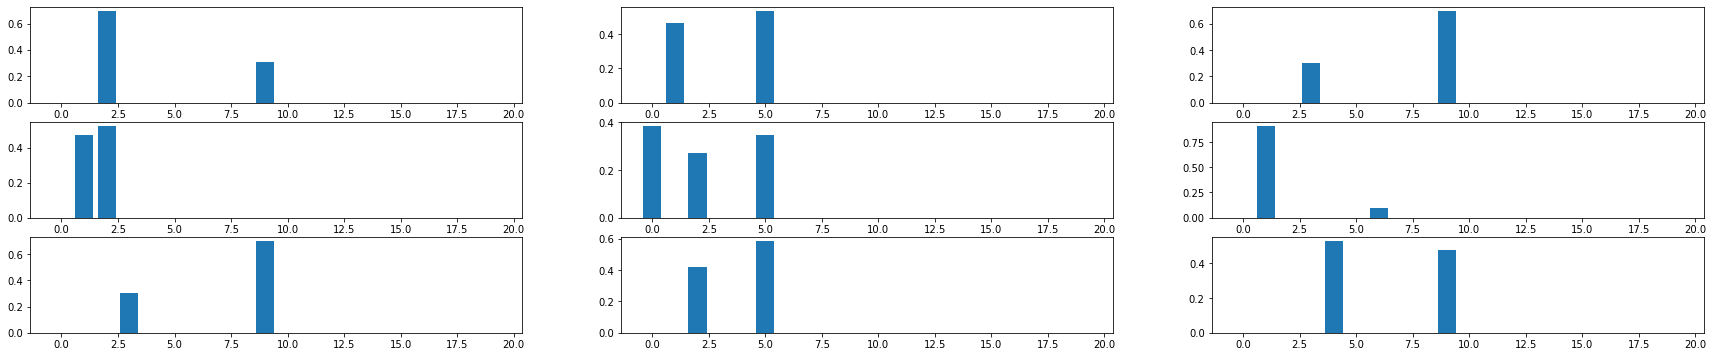

Phase 1
./tmp2/synthetic6_phase01_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


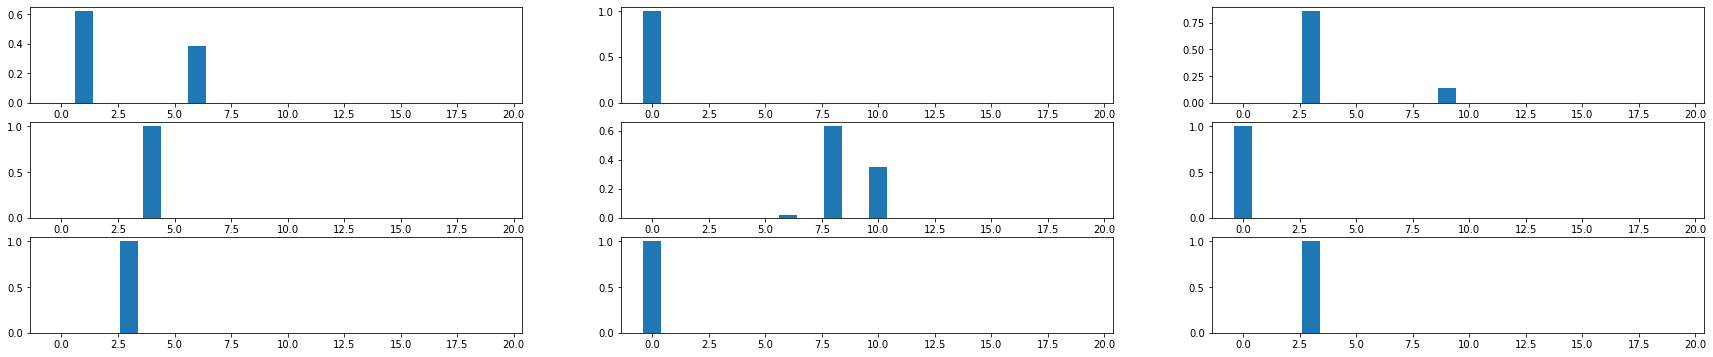

Phase 2
./tmp2/synthetic6_phase02_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


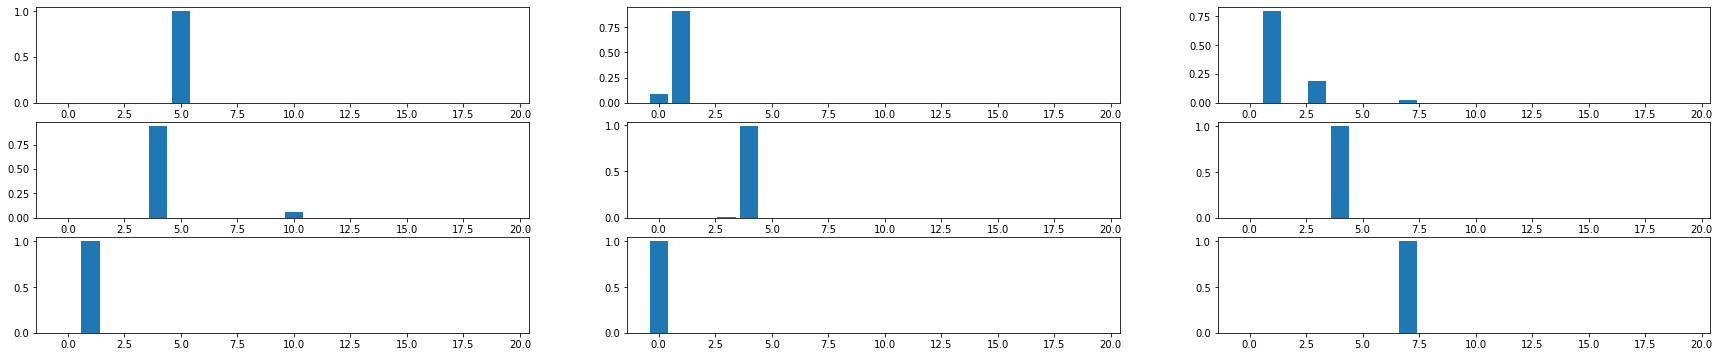

Phase 3
./tmp2/synthetic6_phase03_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


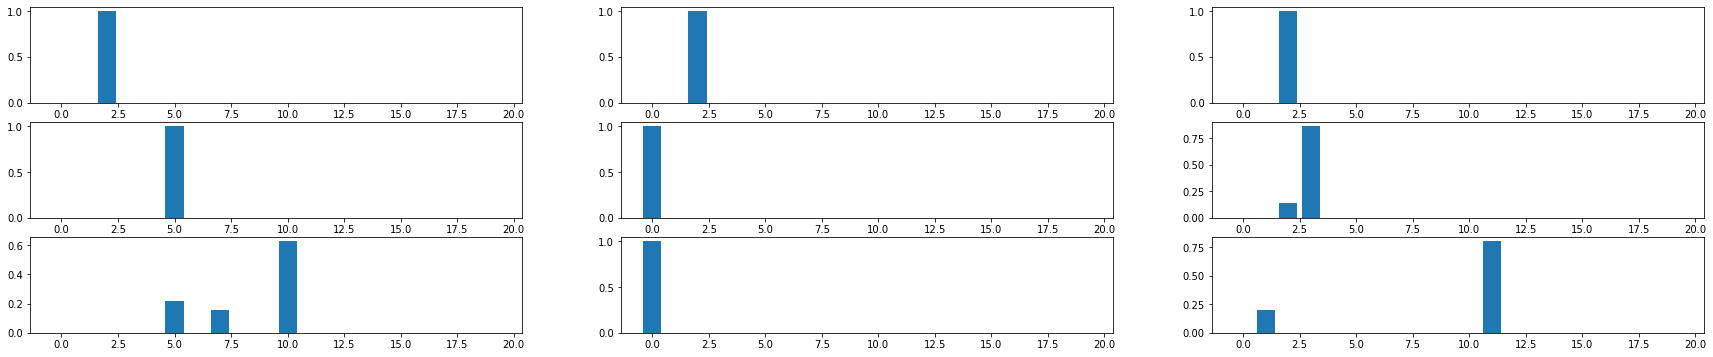

Phase 4
./tmp2/synthetic6_phase04_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


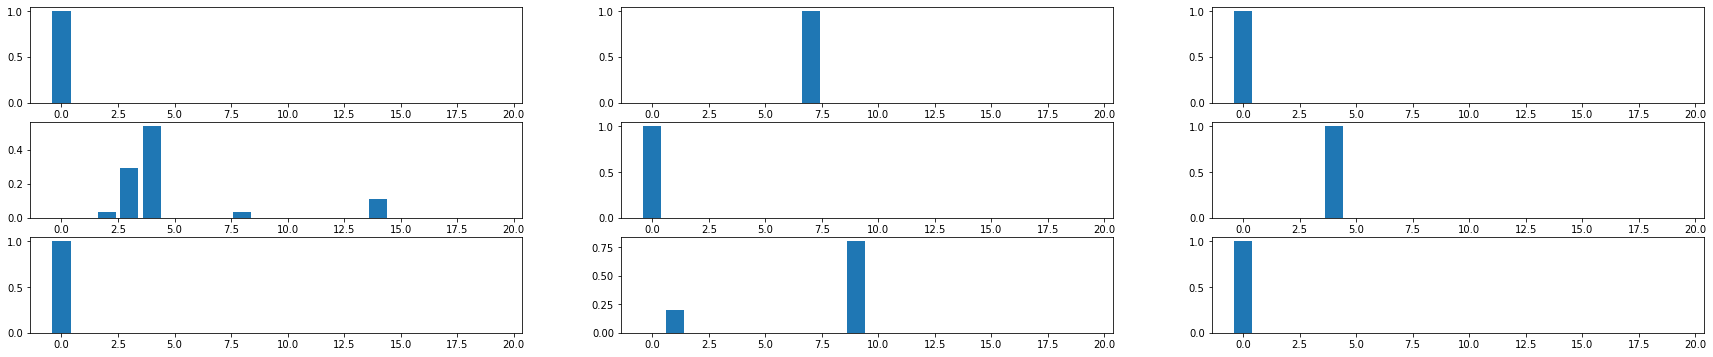

Phase 5
./tmp2/synthetic6_phase05_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


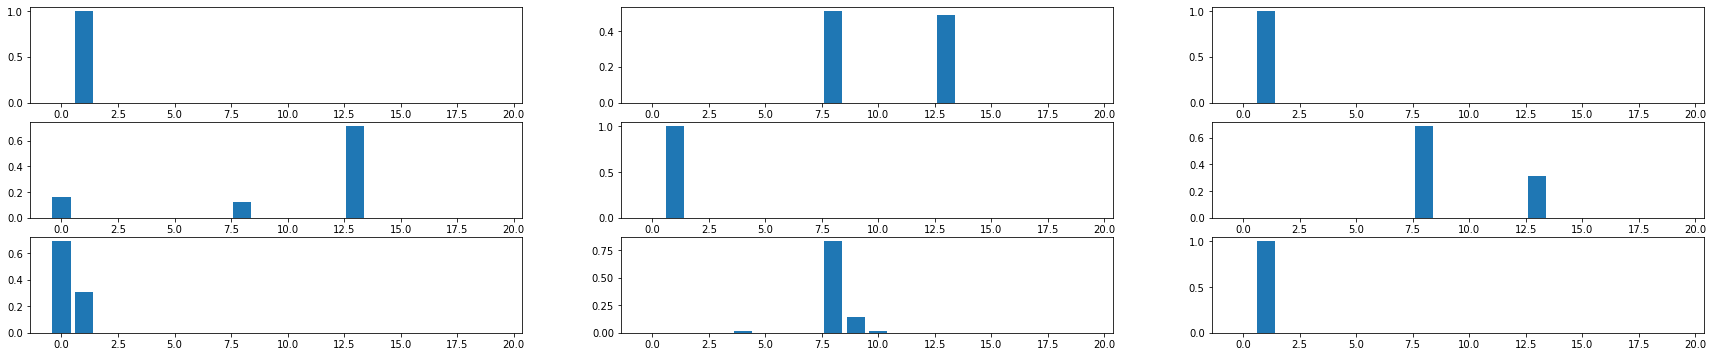

Phase 6
./tmp2/synthetic6_phase06_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


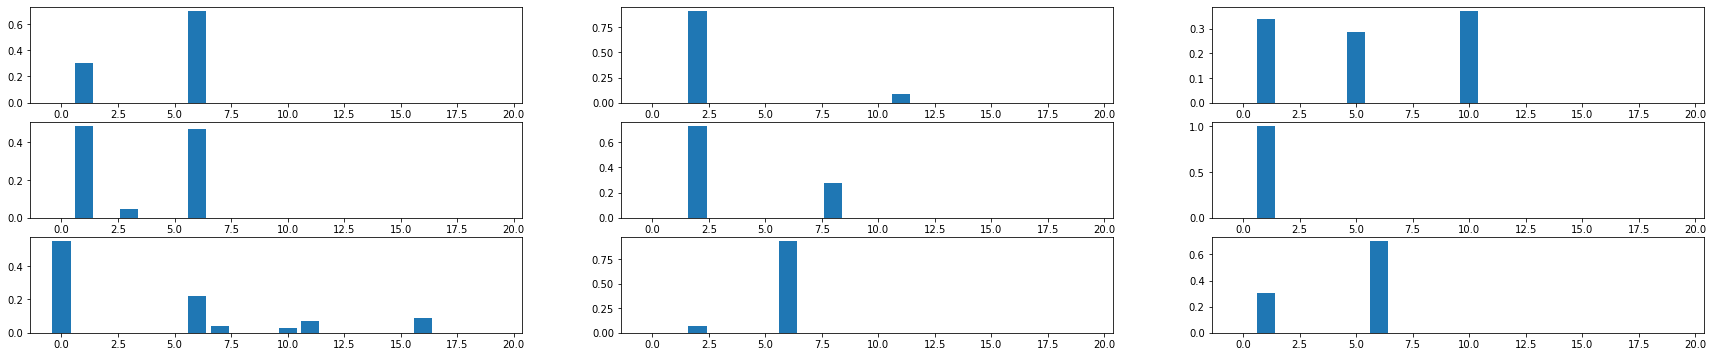

Phase 7
./tmp2/synthetic6_phase07_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


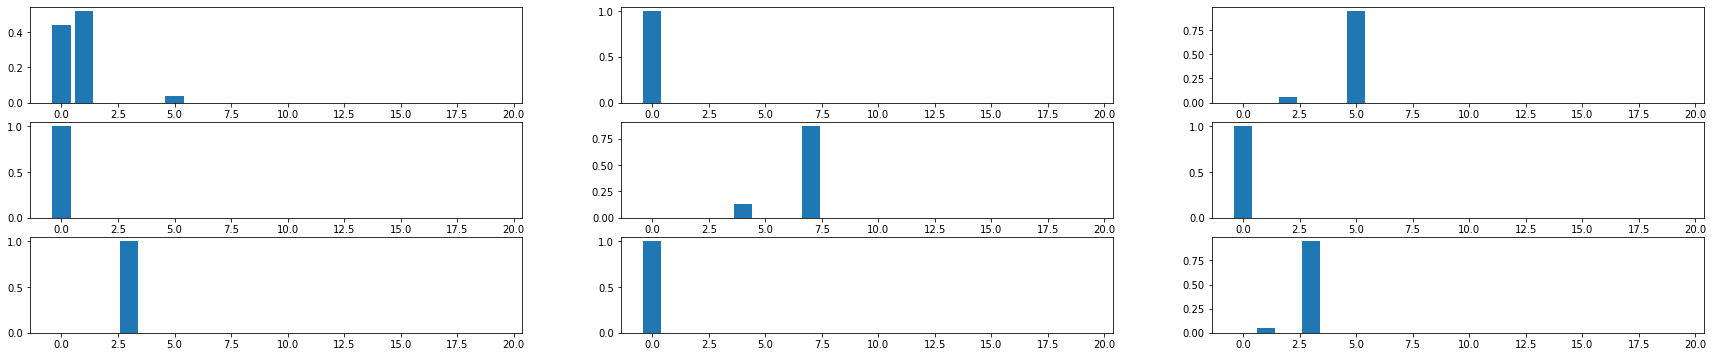

Phase 8
./tmp2/synthetic6_phase08_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


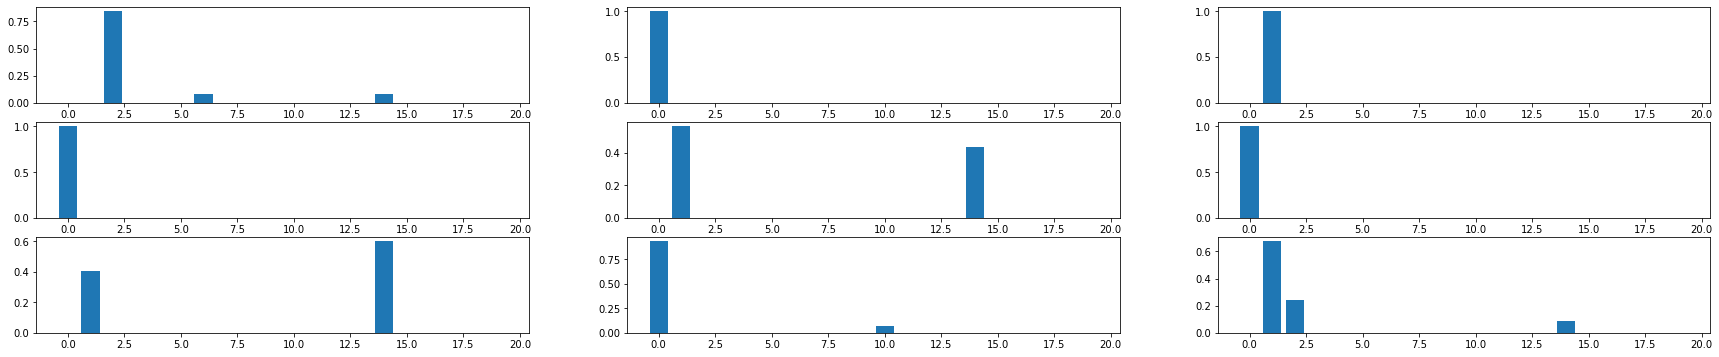

Phase 9
./tmp2/synthetic6_phase09_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


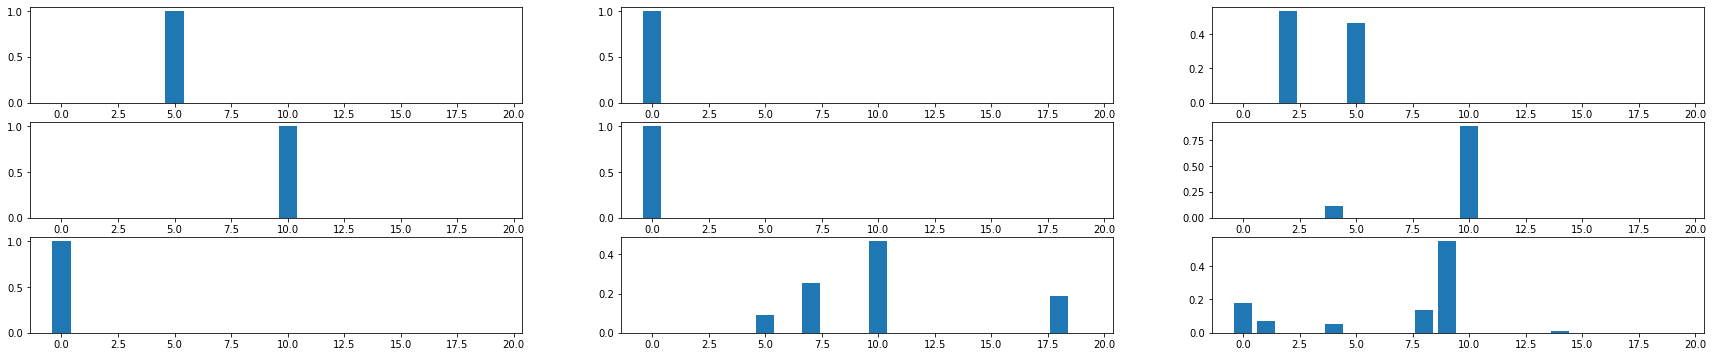

In [6]:
paras={'dataset':ds, 'maxiter':500, 'subn':20, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True',
       'c':0.0025, 'rf':0.0007, 'gamma':0.01, 
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=10)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P
fee = 0.000000
Summary:
    Profit factor: 15.11
    Sharpe ratio: 11.37 ± 4.07
    Ulcer index: 409.39
    Information ratio (wrt UCRP): 11.96
    Appraisal ratio (wrt UCRP): 13.47 ± 0.50
    UCRP sharpe: 1.49 ± 0.73
    Beta / Alpha: 6.49 / 1443.138%
    Annualized return: 204782893.74%
    Annualized volatility: 138.69%
    Longest drawdown: 14 days
    Max drawdown: 55.27%
    Winning days: 87.6%
    Annual turnover: 513.9
        
Total wealth: 1.1087075748595877e+25


<Figure size 720x360 with 0 Axes>

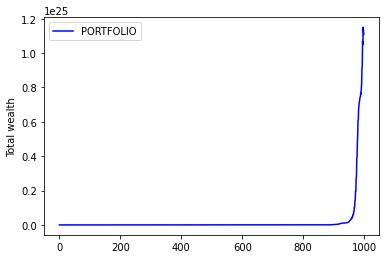

In [7]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras,c=0.0)

In [8]:
strategy_lst = ['G4P_passive(predY0, std_varY0, sample_Y0, cov, paras["passive_eps"], paras["passive_gamma"])']

Phase 0
./tmp2/synthetic6_phase00_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 55 / 100


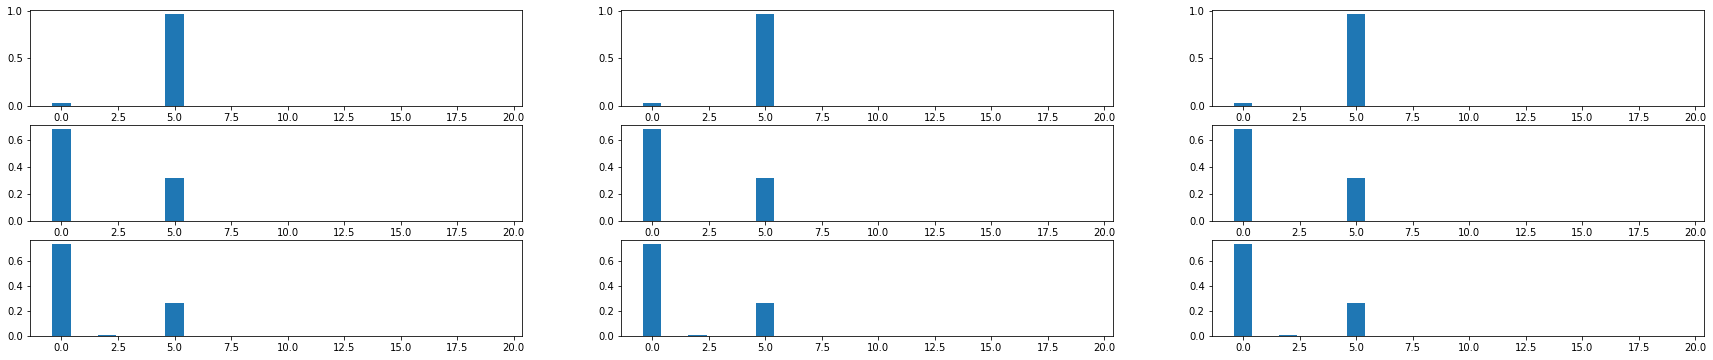

Phase 1
./tmp2/synthetic6_phase01_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 53 / 100


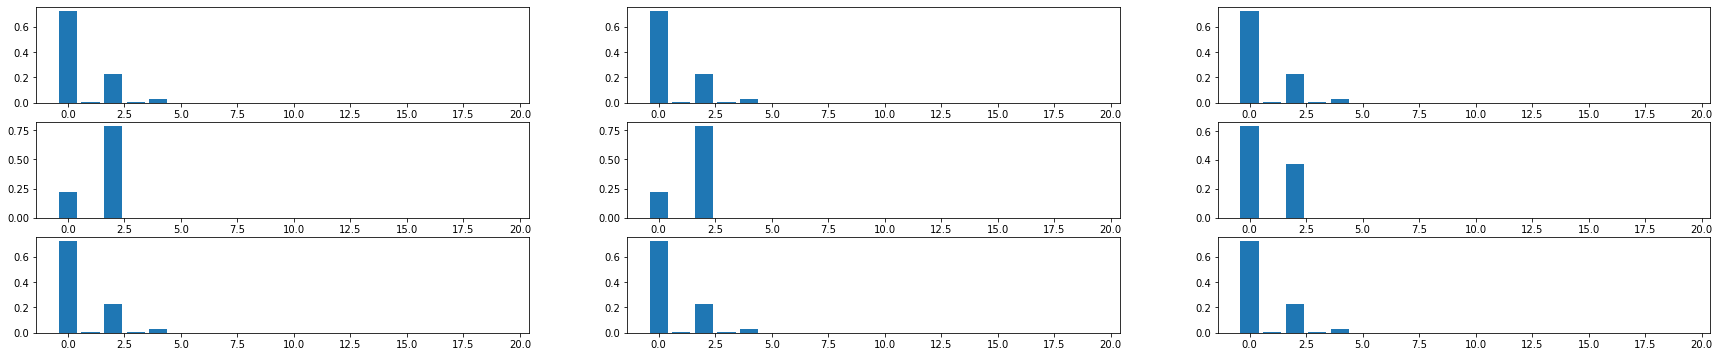

Phase 2
./tmp2/synthetic6_phase02_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 57 / 100


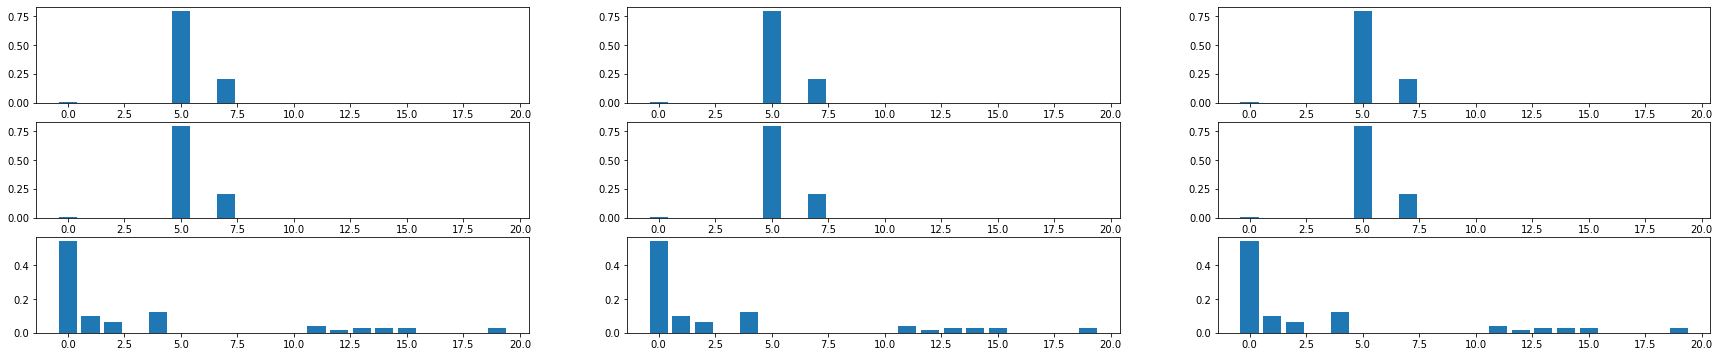

Phase 3
./tmp2/synthetic6_phase03_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 43 / 100


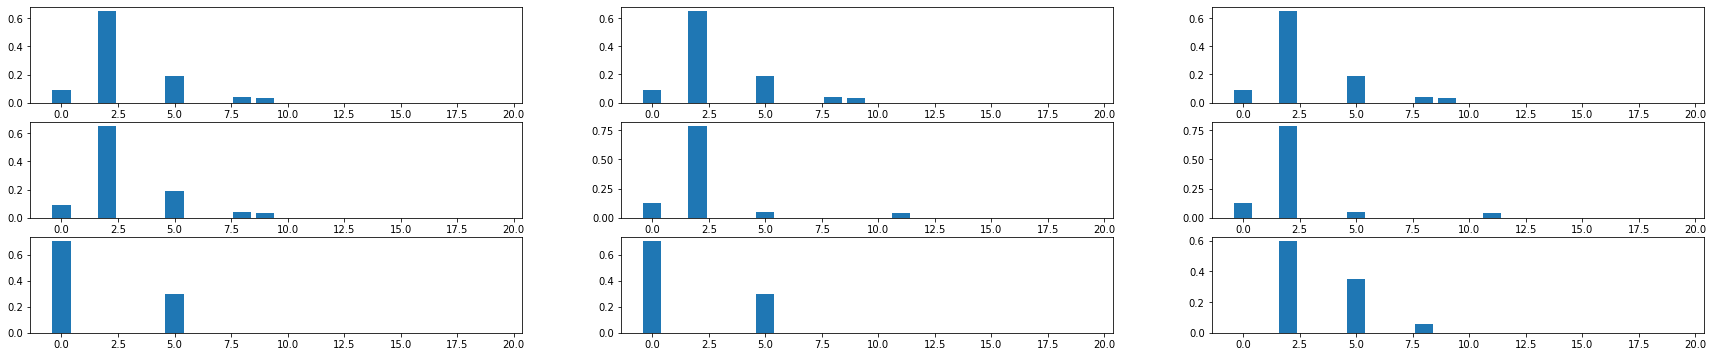

Phase 4
./tmp2/synthetic6_phase04_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 47 / 100


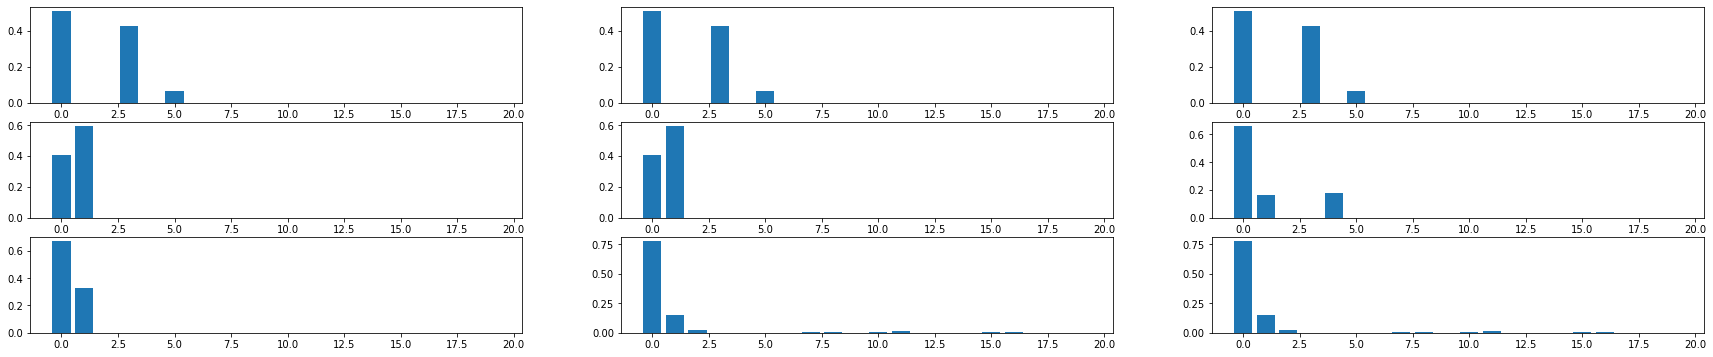

Phase 5
./tmp2/synthetic6_phase05_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 50 / 100


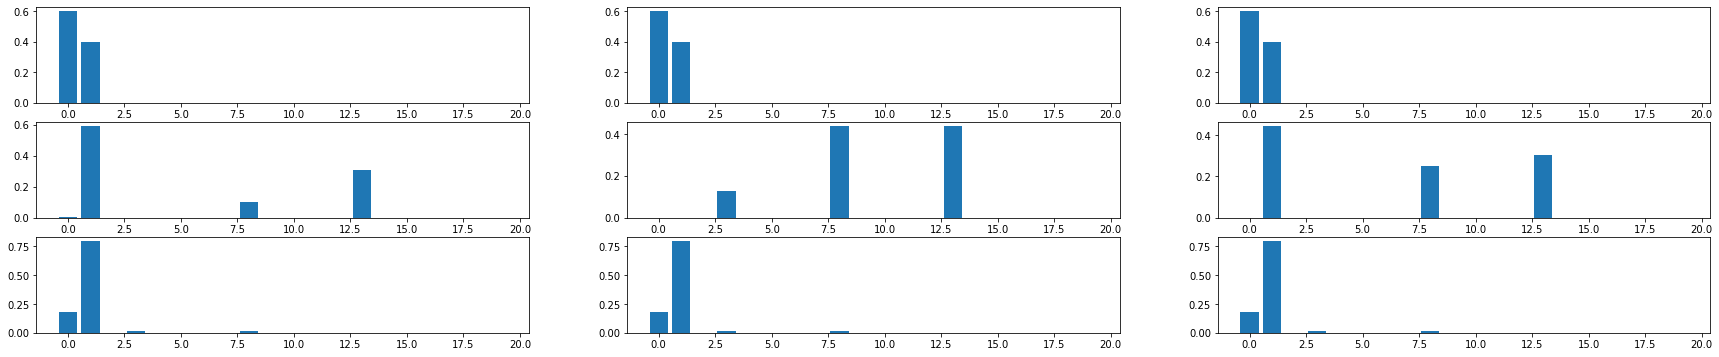

Phase 6
./tmp2/synthetic6_phase06_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 64 / 100


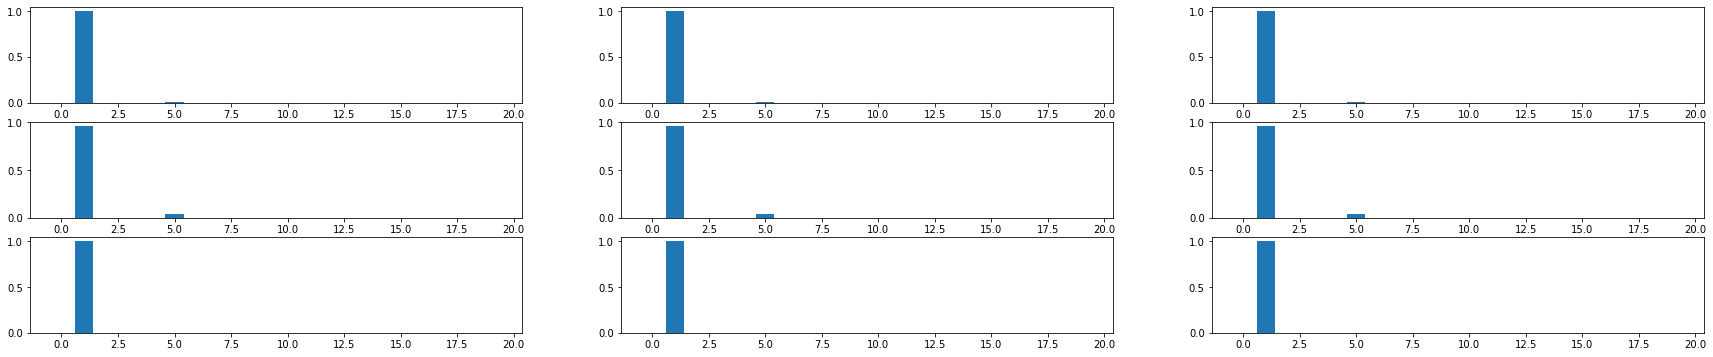

Phase 7
./tmp2/synthetic6_phase07_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 63 / 100


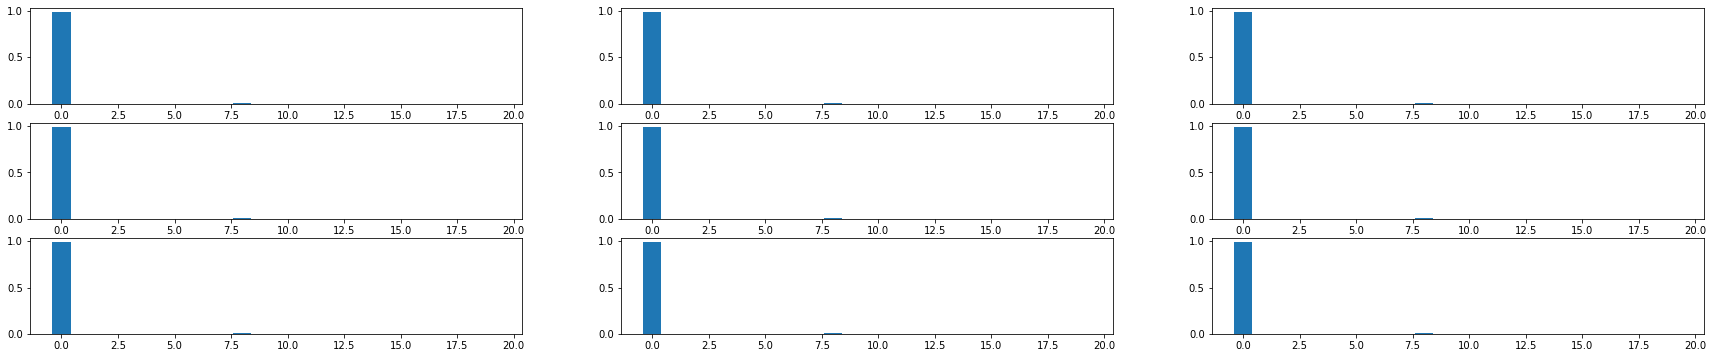

Phase 8
./tmp2/synthetic6_phase08_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 57 / 100


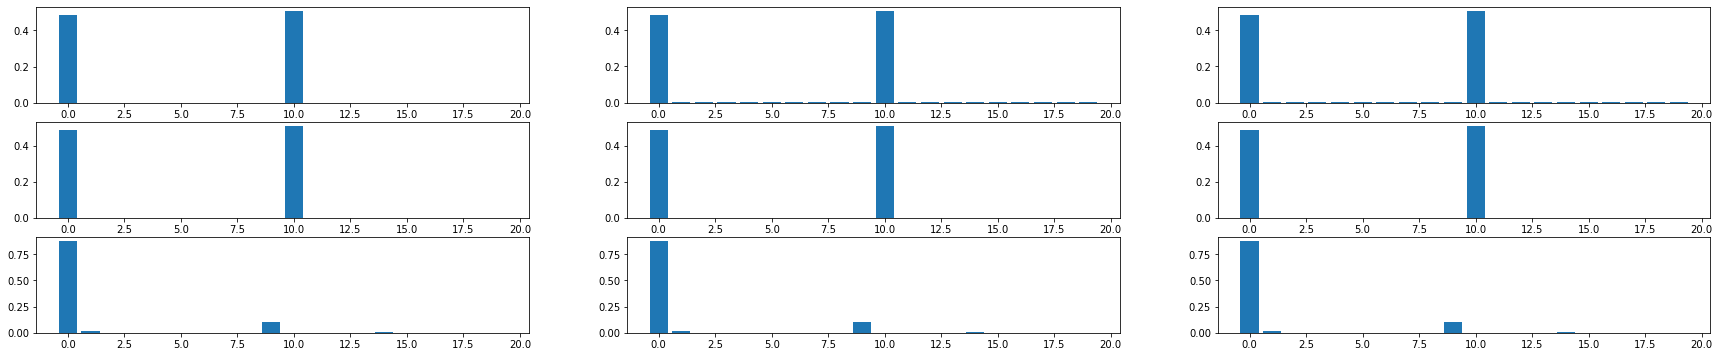

Phase 9
./tmp2/synthetic6_phase09_iter500_subn20_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 54 / 100


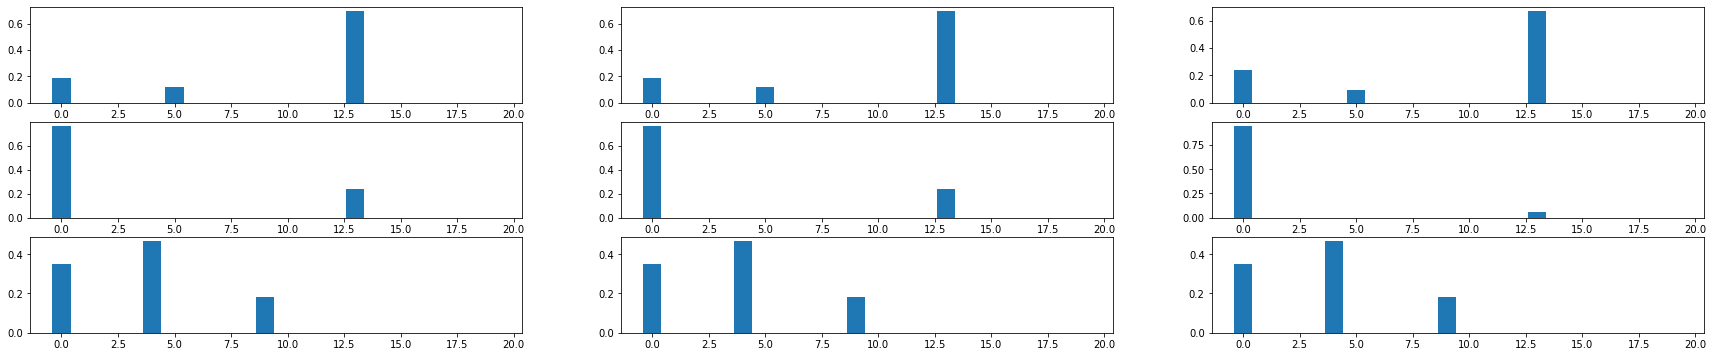

In [9]:
paras={'dataset':ds, 'maxiter':500, 'subn':20, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True',
       'c':0.0025, 'rf':0.0007, 'passive_eps':1.05, 'passive_gamma':0.001,
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=10)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P_passive
fee = 0.000000
Summary:
    Profit factor: 1.34
    Sharpe ratio: 2.35 ± 0.97
    Ulcer index: 32.87
    Information ratio (wrt UCRP): 2.36
    Appraisal ratio (wrt UCRP): 1.80 ± 0.50
    UCRP sharpe: 1.49 ± 0.73
    Beta / Alpha: 6.18 / 163.912%
    Annualized return: 764.48%
    Annualized volatility: 123.98%
    Longest drawdown: 51 days
    Max drawdown: 55.00%
    Winning days: 55.6%
    Annual turnover: 62.8
        
Total wealth: 5215.444444773241


<Figure size 720x360 with 0 Axes>

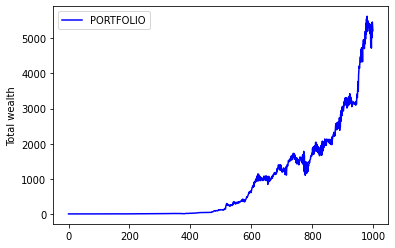

In [10]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras,c=0.0)